**<h1>Fine-Tune Bert Masked-Language Model on Meditations by Marcus Aurelius Book<h1>**

Masked Language Modeling (MLM) trains models like BERT to predict missing words in sentences. It starts by splitting sentences into parts and randomly masking some words. Then, the model learns to guess the masked words based on context.

During training, it adjusts its predictions to match the actual words. This helps the model understand context and language better.

<img src = "https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/MLM.png" height = 300 width = 500>

In [ ]:
# Mount data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set GPU on Enviroment
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### **Import Required Libraries**

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
import matplotlib.pyplot as plt
from transformers import AdamW
from tqdm import tqdm  # for our progress bar

**Intialize the model and tokenizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Load the dataset** <br>
Here we use [The Meditations By Marcus Aurelius Book](https://http://classics.mit.edu/Antoninus/meditations.html) as a Dataset.

In [ ]:
with open('/content/drive/MyDrive/Bert_Model/clean.txt', 'r') as fp:
    text = fp.read().split('\n')

**Data Preprocessing** <br>
As we randomly choosing the mask from the text, that's why we can use any textual data. Here we add 15% masks in the text.

In [ ]:
inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
inputs['labels'] = inputs.input_ids.detach().clone()
# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != 102) * (inputs.input_ids != 0)


selection = []

for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )

for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = 103

During training, we’ll be using a PyTorch DataLoader to load our data. To use this, we’ll need to format our data into a PyTorch Dataset object.

In [ ]:
class MeditationsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
dataset = MeditationsDataset(inputs)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

**Training Phase** <br>
Now we’re ready to move onto our training loop. Before starting our loop we need to set up three things:

*   Move the model to GPU/CPU (GPU if available).
*   Activate model training mode.
*   Initialize an Adam with weighted decay optimizer.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)
# activate training mode
model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

**Now we’re finally set up — we can begin training!**

In [ ]:
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)
epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/254 [00:00<?, ?it/s]<ipython-input-7-6dccb434beb5>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 254/254 [01:20<00:00,  3.16it/s, loss=0.046]


**Training Losses**

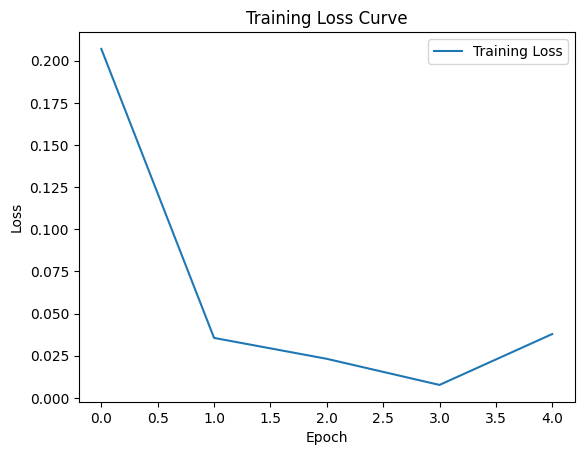

In [ ]:
losses = [
    0.207, 0.0356, 0.0232, 0.00772, 0.0379
]
# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

**Save the model**

In [ ]:
#Save the model
model.save_pretrained('/content/drive/MyDrive/Bert_Model/5Epochs')

**Test the model** <br>
 Here we pass the *text* with a masked token is tokenized and passed through the model for inference.

 The top-5 predictions for the masked token are then decoded and printed along with their probabilities.

In [ ]:
# Example input text with a masked token
text = "Begin the [MASK] by saying"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Tokenize the input text
inputs = tokenizer(text, return_tensors='pt').to(device)

# Retrieve the token index of the masked token
mask_token_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1][0]

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the logits for the masked token
masked_token_logits = outputs.logits[0, mask_token_index.item()].squeeze().to('cpu')


# Get the top k predictions and their probabilities
top_k_tokens = torch.topk(masked_token_logits, k=5, dim=-1)
top_k_probs = torch.softmax(top_k_tokens.values, dim=-1)

# Decode the predicted tokens
predicted_tokens = []
for token in top_k_tokens.indices:
    predicted_tokens.append(tokenizer.decode([token.item()]))

# Print the top k predictions and their probabilities
for token, prob in zip(predicted_tokens, top_k_probs):
    print(f"{token}: {prob.item()}")

[PAD]: 0.4947005808353424
show: 0.15845952928066254
game: 0.13084542751312256
series: 0.11455515027046204
process: 0.10143933445215225


**Load the save model**

In [ ]:
# Path to the directory where the model is saved
model_path = "/content/drive/MyDrive/Bert_Model"

# Load the model
model = BertForMaskedLM.from_pretrained(model_path)